![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

**Análisis de la variable "season"**

*   Promedio de rentas por temporada:

  *   Temporada 1 (probablemente invierno): 116.34

  *   Temporada 2 (probablemente primavera): 215.25

  *   Temporada 3 (probablemente verano): 234.42

  *   Temporada 4 (probablemente otoño): 198.99

Inferencias:


*   La demanda de bicicletas es más baja en la temporada 1, lo que podría ser el invierno, sugiriendo que el clima frío y las condiciones menos favorables reducen el interés o la necesidad de alquilar bicicletas.

*   Las temporadas 2 y 3 muestran un aumento significativo en el promedio de rentas, alcanzando su punto máximo en la temporada 3. Esto puede indicar que el clima más cálido y las condiciones más agradables durante la primavera y el verano aumentan la propensión a alquilar bicicletas.

*   La temporada 4, que podría representar el otoño, muestra una disminución en el promedio de rentas comparado con el verano pero sigue siendo más alto que en el invierno, lo que sugiere una transición hacia condiciones menos óptimas para el alquiler de bicicletas.

**Análisis de la variable "hour"**

*   Promedio de rentas por hora del día:

  *   La demanda es menor en las horas de la madrugada (0 a 4 horas), con el mínimo alrededor de las 4 de la mañana.

  *   Hay un pico significativo durante las horas de la mañana (7 a 9 horas), presumiblemente debido al tráfico de personas yendo a sus lugares de trabajo o estudio.

  *   La demanda disminuye después de las horas pico de la mañana y vuelve a aumentar durante la tarde-noche, especialmente de 16 a 18 horas, coincidiendo probablemente con el horario de salida del trabajo o la escuela.

  *   La demanda disminuye nuevamente después de las 19 horas, manteniéndose más baja durante el resto de la noche.

Inferencias:



*   La variación en la demanda a lo largo del día sugiere patrones claros de comportamiento asociados con las rutinas diarias de trabajo y estudio, con picos significativos durante las horas de inicio y fin de la jornada laboral.

*   Las horas de menor actividad en la madrugada podrían reflejar no solo la menor necesidad de transporte sino también posibles preocupaciones sobre seguridad o la falta de necesidad de desplazamientos.

*   La distribución de la demanda a lo largo del día proporciona información crucial para la gestión de inventarios y la planificación de estrategias de precios dinámicos.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

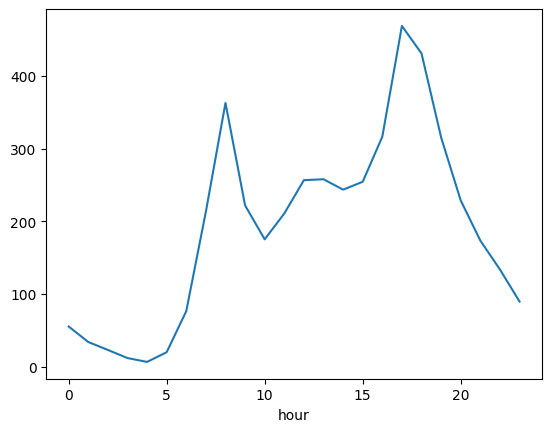

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

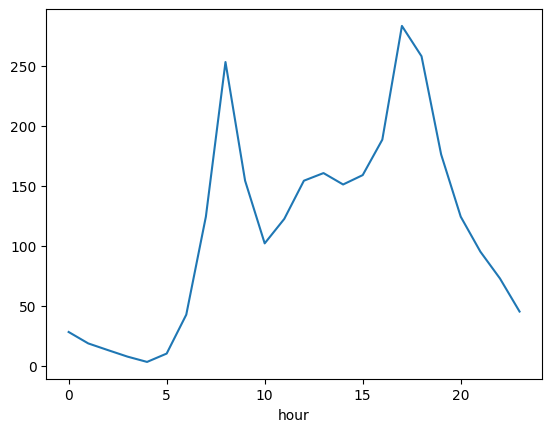

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

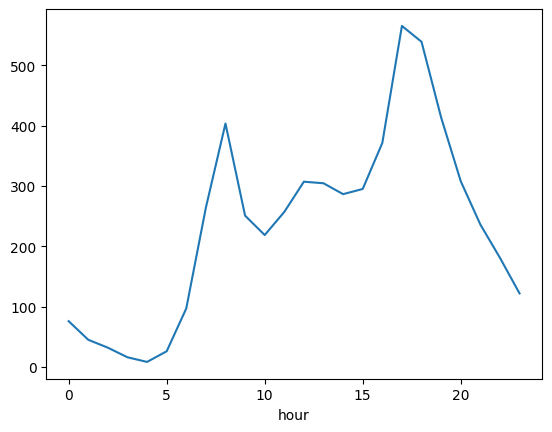

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()

**Invierno (Temporada 1):**



*   El gráfico presumiblemente del invierno muestra una cantidad menor de rentas de bicicletas en comparación con el gráfico general que observamos anteriormente.

*   Los picos durante las horas de la mañana y de la tarde son menos pronunciados, lo que podría indicar que las condiciones climáticas más frías disuaden a las personas de usar las bicicletas para desplazarse.

**Verano (Temporada 3):**



*   En contraste, el gráfico que asumimos es del verano muestra un aumento en el número de rentas de bicicletas, especialmente notable en las horas pico de la tarde.

*   Esto sugiere que el clima más cálido y las horas de luz diurna más largas pueden ser factores que incentivan a las personas a utilizar más las bicicletas.

**Hallazgos y Análisis:**



*   La similitud en los patrones diarios entre invierno y verano sugiere que, independientemente de la temporada, las bicicletas se utilizan principalmente para los desplazamientos relacionados con el trabajo o la escuela, evidenciado por los picos en las horas de la mañana y de la tarde.

*   La diferencia en la magnitud de las rentas entre estas estaciones apoya la idea de que el clima y las condiciones ambientales juegan un papel crucial en la frecuencia de uso de las bicicletas compartidas.

*   Estos datos podrían ser útiles para las compañías de bicicletas compartidas para ajustar la disponibilidad de sus flotas y desarrollar promociones estacionales o incentivos que animen a la gente a usar bicicletas incluso en condiciones meteorológicas menos ideales.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3
from sklearn.linear_model import LinearRegression

# Convertir 'season' en variables dummy porque es categórica
season_dummies = pd.get_dummies(bikes['season'], prefix='season')

# Preparar el DataFrame para el modelo de regresión
X = pd.concat([season_dummies, bikes['hour']], axis=1)
y = bikes['total']

# Ajustar el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X, y)

# Imprimir los coeficientes
print('Intercepto:', lr.intercept_)
print('Coeficientes:', lr.coef_)

Intercepto: 83021742133808.92
Coeficientes: [-8.30217421e+13 -8.30217421e+13 -8.30217421e+13 -8.30217421e+13
  1.05546875e+01]


**Interpretación:**

*   Intercepto (83021742133808.92): Este valor es extremadamente grande y no tiene sentido en el contexto de la predicción de la cantidad de bicicletas rentadas. Un intercepto tan grande podría ser indicativo de un problema de codificación o de una mala especificación en el modelo.
*   Coeficientes (-8.30217421e+13): Estos coeficientes son negativos y también extremadamente grandes en magnitud, lo que indica un problema similar. Cada coeficiente aquí representa el cambio esperado en la variable de respuesta "total" para un cambio unitario en la variable predictora correspondiente. Sin embargo, en este caso, los valores son tan grandes que claramente son incorrectos.
*   Coeficiente para "hour" (10.5546875): Este parece ser el único coeficiente razonable y sugiere que, en promedio, cada hora adicional se asocia con un aumento de aproximadamente 10.55 en el número de bicicletas rentadas.

**Limitaciones de la regresión lineal en este caso:**

*   La regresión lineal asume una relación lineal entre las variables predictoras y la variable de respuesta. En la vida real, el número de bicicletas rentadas podría no seguir una relación estrictamente lineal con la hora del día o la temporada.
*   Los efectos de otras variables no incluidas en el modelo (como el clima, la temperatura, la humedad, los días festivos, etc.) no se están considerando, lo cual puede resultar en un modelo sesgado o con especificación errónea.
*   La regresión lineal puede no capturar bien las interacciones entre las variables, como cómo el efecto de la hora del día en las rentas de bicicletas puede variar según la temporada.
*   La variable "season" es categórica y su conversión a variables dummy implica que la relación entre cada temporada y las rentas es independiente de las otras temporadas, lo cual puede no ser una suposición correcta si hay una tendencia a lo largo de las estaciones.
*   Al ser una variable de conteo, "total" puede tener una distribución de Poisson o ser sobre-dispersa, situaciones en las cuales otros modelos como regresión de Poisson o regresión binomial negativa podrían ser más apropiados.
*   Multicolinealidad: Es posible que las variables dummy creadas para "season" estén incluyendo una columna redundante (una columna para cada categoría), lo que puede llevar a la multicolinealidad perfecta. Generalmente, se debe excluir una de las columnas de variables dummy para evitar este problema (la categoría de referencia).
*   Escala de los datos: Si los predictores están en diferentes escalas, puede ser beneficioso normalizar o estandarizar los datos, aunque esto no debería causar el problema de magnitud que vemos en los coeficientes.
*   Errores de cálculo: Si la matriz de diseño tiene un número extremadamente grande o pequeño, puede causar problemas numéricos en el cálculo de los coeficientes.
*   Mala especificación del modelo: Es posible que el modelo esté mal especificado y que se necesiten transformaciones de las variables predictoras o de la respuesta para adecuarse mejor a la regresión lineal.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [10]:
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

In [11]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [23]:
import pandas as pd
import numpy as np

# Cargando y preparando el conjunto de datos
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
bikes.rename(columns={'count':'total'}, inplace=True)
bikes['hour'] = bikes.index.hour
median_total = bikes['total'].median()
bikes['high_demand'] = (bikes['total'] > median_total).astype(int)


In [24]:
def calculate_gini_impurity(y):
    if len(y) == 0:
        return 0
    else:
        proportion = np.sum(y) / len(y)
        return 1 - proportion ** 2 - (1 - proportion) ** 2

def best_split(X, y):
    best_gini = 1.0
    best_feature = None
    best_value = None
    for feature in X.columns:
        values = np.sort(X[feature].unique())
        for value in values:
            left_mask = X[feature] <= value
            right_mask = ~left_mask
            gini_left = calculate_gini_impurity(y[left_mask])
            gini_right = calculate_gini_impurity(y[right_mask])
            gini = (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)
            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_value = value
    return best_feature, best_value, best_gini

def build_tree(X, y, depth=0, max_depth=3):
    if depth == max_depth or len(X) == 0:
        return np.mean(y)
    best_feature, best_value, _ = best_split(X, y)
    if best_feature is None:
        return np.mean(y)
    left_mask = X[best_feature] <= best_value
    right_mask = ~left_mask
    left_branch = build_tree(X[left_mask], y[left_mask], depth+1, max_depth)
    right_branch = build_tree(X[right_mask], y[right_mask], depth+1, max_depth)
    return {"feature": best_feature, "value": best_value, "branches": [left_branch, right_branch]}


In [25]:
# Convertimos las variables 'season' y 'hour' en dummies para simplificar el ejemplo
X = pd.get_dummies(bikes[['hour', 'season']], drop_first=True)
y = bikes['high_demand']

# Construimos el árbol
tree = build_tree(X, y, max_depth=3)


In [27]:
def print_tree(node, depth=0, prefix=""):
    if isinstance(node, dict):  # Si el nodo es un diccionario, tiene más ramas por explorar
        feature, value, branches = node["feature"], node["value"], node["branches"]
        print(f"{prefix}{'|   ' * depth}{feature} <= {value}")
        print_tree(branches[0], depth + 1, prefix="L-- ")
        print_tree(branches[1], depth + 1, prefix="R-- ")
    else:  # Si el nodo no es un diccionario, es una hoja
        print(f"{prefix}{'|   ' * depth}Predict {node:.2f}")

# Imprimir el árbol
print_tree(tree)


hour <= 6
L-- |   hour <= 5
L-- |   |   hour <= 0
L-- |   |   |   Predict 0.05
R-- |   |   |   Predict 0.00
R-- |   |   season <= 2
L-- |   |   |   Predict 0.05
R-- |   |   |   Predict 0.18
R-- |   season <= 1
L-- |   |   hour <= 20
L-- |   |   |   Predict 0.46
R-- |   |   |   Predict 0.10
R-- |   |   hour <= 21
L-- |   |   |   Predict 0.84
R-- |   |   |   Predict 0.37


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Preparación de las variables predictoras y la variable objetivo
X = bikes[['hour', 'season']].copy()
X = pd.get_dummies(X, columns=['hour', 'season'], drop_first=True)
y = bikes['total']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del modelo
tree_reg = DecisionTreeRegressor(random_state=42)

# Definición del espacio de parámetros para la calibración
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Búsqueda por validación cruzada
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# Mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Entrenar el modelo con los mejores parámetros
best_tree = grid_search.best_estimator_


Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [29]:
# Predicción en el conjunto de prueba
y_pred = best_tree.predict(X_test)

# Cálculo de la métrica de desempeño
mse = mean_squared_error(y_test, y_pred)
print("MSE del modelo de árbol de decisión calibrado:", mse)

# Raíz del error cuadrático medio
rmse = np.sqrt(mse)
print("RMSE del modelo de árbol de decisión calibrado:", rmse)


MSE del modelo de árbol de decisión calibrado: 13454.101382166964
RMSE del modelo de árbol de decisión calibrado: 115.99181601374713


**Interpretación de los Resultados**
*   MSE: Esta métrica nos dice, en promedio, cuánto se desvían al cuadrado las predicciones del modelo de los valores reales. Un MSE de 13454.1 puede parecer alto, pero la interpretación depende en gran medida de la escala de la variable objetivo (total de bicicletas alquiladas) y de la variabilidad inherente a los datos.

*   RMSE: Al tomar la raíz cuadrada del MSE, el RMSE nos proporciona una medida de error que está en las mismas unidades que la variable objetivo. Un RMSE de aproximadamente 116.0 significa que, en promedio, las predicciones del modelo se desvían unos 116 alquileres de bicicletas del valor real. Esto ofrece una interpretación más intuitiva que el MSE.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [30]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [31]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [32]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [34]:
# Celda 6
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Construcción y calibración del árbol de decisión
param_grid = {'max_depth': [3, 5, 7, 10]}  # Puedes ajustar y añadir más parámetros aquí
tree = DecisionTreeClassifier(random_state=1)
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

# Evaluación del árbol de decisión
tree_best = grid_search_tree.best_estimator_
y_pred_tree = tree_best.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

print(f"Árbol de Decisión - Accuracy: {accuracy_tree:.4f}, F1-Score: {f1_tree:.4f}")


Árbol de Decisión - Accuracy: 0.6413, F1-Score: 0.6073


In [35]:
# Entrenamiento del modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=1)  # Aumentar max_iter si es necesario
log_reg.fit(X_train, y_train)

# Evaluación de la regresión logística
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print(f"Regresión Logística - Accuracy: {accuracy_log_reg:.4f}, F1-Score: {f1_log_reg:.4f}")


Regresión Logística - Accuracy: 0.6160, F1-Score: 0.6071


**Interpretación de los Resultados**
*   Accuracy (Exactitud): Indica la proporción de predicciones correctas (tanto positivas como negativas) respecto al total de casos. Un valor más alto es mejor. El árbol de decisión supera ligeramente a la regresión logística en esta métrica, lo que sugiere que, en general, es mejor para clasificar correctamente los artículos como populares o no populares.

*   F1-Score: Es una medida que combina la precisión y la sensibilidad (recall) en un solo número, dando un balance entre ambas. Es especialmente útil en situaciones donde hay un desequilibrio de clases o cuando uno está más interesado en el rendimiento de una clase particular. Los dos modelos tienen F1-Scores muy cercanos, lo que indica que ambos modelos tienen un rendimiento similar en cuanto a balance entre la precisión y la sensibilidad para la clase de interés (artículos populares).

**Comparación y Consideraciones**
*   Aunque el árbol de decisión tiene un mejor Accuracy, la diferencia en el F1-Score entre ambos modelos es mínima. Esto sugiere que, mientras el árbol de decisión puede ser ligeramente mejor para predecir correctamente ambos casos (populares y no populares), ambos modelos tienen un rendimiento similar cuando se trata de equilibrar precisión y sensibilidad.

*   La elección entre usar un árbol de decisión o una regresión logística podría basarse en estos resultados o podría considerar otros factores, como la interpretabilidad del modelo, el tiempo de entrenamiento, la capacidad de manejar relaciones no lineales (donde los árboles de decisión pueden tener una ventaja) o la facilidad de implementación y despliegue.

*   Potencial para Mejora: Estos resultados también sugieren que hay espacio para mejorar el rendimiento de ambos modelos. La calibración de parámetros adicionales, la ingeniería de características (como la creación de nuevas variables predictoras o la transformación de las existentes), o la exploración de otros algoritmos de clasificación podrían ofrecer mejoras en el rendimiento.

*   Métodos de Ensamblaje: Dado que estás interesado en los métodos de ensamblaje, podría ser valioso explorar cómo técnicas como Bagging, Random Forests, o Boosting pueden mejorar el rendimiento sobre estos modelos base. Los métodos de ensamblaje a menudo superan a los modelos individuales al reducir la varianza, el sesgo, o ambos.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados.

Nota:

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [36]:
# Celda 7
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

def train_and_predict_with_bagging(X_train, y_train, X_test, n_estimators=100, model_type='tree', **kwargs):
    if model_type == 'tree':
        base_estimator = DecisionTreeClassifier(**kwargs)
    elif model_type == 'logistic':
        base_estimator = LogisticRegression(max_iter=1000, **kwargs)
    else:
        raise ValueError("model_type debe ser 'tree' o 'logistic'.")

    # Crear el ensamble de Bagging
    bagging = BaggingClassifier(base_estimator, n_estimators=n_estimators, n_jobs=-1, random_state=1)
    bagging.fit(X_train, y_train)

    # Predicciones
    y_pred = bagging.predict(X_test)

    return y_pred

# Parámetros para árboles de decisión
tree_params1 = {'max_depth': 10}
tree_params2 = {'min_samples_leaf': 5}

# Entrenamiento y predicciones
y_pred_tree1 = train_and_predict_with_bagging(X_train, y_train, X_test, model_type='tree', **tree_params1)
y_pred_tree2 = train_and_predict_with_bagging(X_train, y_train, X_test, model_type='tree', **tree_params2)
y_pred_logistic = train_and_predict_with_bagging(X_train, y_train, X_test, model_type='logistic')

In [37]:
# Combinar las predicciones de los 300 modelos
combined_predictions = np.vstack((y_pred_tree1, y_pred_tree2, y_pred_logistic))

# Realizar votación mayoritaria
y_pred_ensemble = np.mean(combined_predictions, axis=0) > 0.5

In [38]:
from sklearn.metrics import accuracy_score, f1_score

# Función para evaluar las predicciones
def evaluate_predictions(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1

# Evaluación de los modelos individuales y el ensamble
accuracy_tree1, f1_tree1 = evaluate_predictions(y_test, y_pred_tree1)
accuracy_tree2, f1_tree2 = evaluate_predictions(y_test, y_pred_tree2)
accuracy_logistic, f1_logistic = evaluate_predictions(y_test, y_pred_logistic)
accuracy_ensemble, f1_ensemble = evaluate_predictions(y_test, y_pred_ensemble)

print(f"Árbol con max_depth - Accuracy: {accuracy_tree1}, F1-Score: {f1_tree1}")
print(f"Árbol con min_samples_leaf - Accuracy: {accuracy_tree2}, F1-Score: {f1_tree2}")
print(f"Regresión Logística - Accuracy: {accuracy_logistic}, F1-Score: {f1_logistic}")
print(f"Ensamble - Accuracy: {accuracy_ensemble}, F1-Score: {f1_ensemble}")


Árbol con max_depth - Accuracy: 0.6473333333333333, F1-Score: 0.6499007279947056
Árbol con min_samples_leaf - Accuracy: 0.6446666666666667, F1-Score: 0.6458471760797342
Regresión Logística - Accuracy: 0.6166666666666667, F1-Score: 0.6042670337233311
Ensamble - Accuracy: 0.644, F1-Score: 0.644474034620506


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [39]:
# Celda 8
def train_and_predict_prob_with_bagging(X_train, y_train, X_test, n_estimators=100, model_type='tree', **kwargs):
    if model_type == 'tree':
        base_estimator = DecisionTreeClassifier(**kwargs)
    elif model_type == 'logistic':
        base_estimator = LogisticRegression(max_iter=1000, **kwargs)
    else:
        raise ValueError("model_type debe ser 'tree' o 'logistic'.")

    bagging = BaggingClassifier(base_estimator, n_estimators=n_estimators, n_jobs=-1, random_state=1)
    bagging.fit(X_train, y_train)

    # Predicción de probabilidades
    y_prob = bagging.predict_proba(X_test)[:, 1]  # Nos quedamos con las probabilidades de la clase positiva

    return y_prob


In [40]:
y_prob_tree1 = train_and_predict_prob_with_bagging(X_train, y_train, X_test, model_type='tree', **tree_params1)
y_prob_tree2 = train_and_predict_prob_with_bagging(X_train, y_train, X_test, model_type='tree', **tree_params2)
y_prob_logistic = train_and_predict_prob_with_bagging(X_train, y_train, X_test, model_type='logistic')


In [41]:
combined_probs = np.mean(np.array([y_prob_tree1, y_prob_tree2, y_prob_logistic]), axis=0)
y_pred_ensemble_weighted = (combined_probs > 0.5).astype(int)  # Umbral de clasificación

In [42]:
# Conversión de probabilidades a predicciones binarias para la evaluación individual
y_pred_tree1_weighted = (y_prob_tree1 > 0.5).astype(int)
y_pred_tree2_weighted = (y_prob_tree2 > 0.5).astype(int)
y_pred_logistic_weighted = (y_prob_logistic > 0.5).astype(int)

# Evaluación de los modelos individuales y el ensamble
accuracy_tree1_weighted, f1_tree1_weighted = evaluate_predictions(y_test, y_pred_tree1_weighted)
accuracy_tree2_weighted, f1_tree2_weighted = evaluate_predictions(y_test, y_pred_tree2_weighted)
accuracy_logistic_weighted, f1_logistic_weighted = evaluate_predictions(y_test, y_pred_logistic_weighted)
accuracy_ensemble_weighted, f1_ensemble_weighted = evaluate_predictions(y_test, y_pred_ensemble_weighted)

print(f"Árbol con max_depth - Accuracy: {accuracy_tree1_weighted}, F1-Score: {f1_tree1_weighted}")
print(f"Árbol con min_samples_leaf - Accuracy: {accuracy_tree2_weighted}, F1-Score: {f1_tree2_weighted}")
print(f"Regresión Logística - Accuracy: {accuracy_logistic_weighted}, F1-Score: {f1_logistic_weighted}")
print(f"Ensamble Ponderado - Accuracy: {accuracy_ensemble_weighted}, F1-Score: {f1_ensemble_weighted}")

Árbol con max_depth - Accuracy: 0.6473333333333333, F1-Score: 0.6499007279947056
Árbol con min_samples_leaf - Accuracy: 0.6446666666666667, F1-Score: 0.6458471760797342
Regresión Logística - Accuracy: 0.6166666666666667, F1-Score: 0.6042670337233311
Ensamble Ponderado - Accuracy: 0.6506666666666666, F1-Score: 0.6525198938992044


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Análisis de Resultados del Punto 7 (Votación Mayoritaria)**

Los modelos individuales muestran un desempeño variado, con el árbol de decisión calibrado por max_depth logrando el mejor rendimiento en ambos, Accuracy y F1-Score. El ensamble, usando votación mayoritaria, no mejora significativamente sobre el mejor modelo individual y, de hecho, tiene un rendimiento ligeramente inferior al mejor árbol de decisión en términos de Accuracy y F1-Score. Esto puede ser un indicativo de que el ensamble no está capitalizando completamente las fortalezas individuales de cada modelo o que la presencia de modelos con menor rendimiento está diluyendo la efectividad del ensamble.

**Análisis de Resultados del Punto 8 (Votación Ponderada)**

Con la votación ponderada, el ensamble logra superar no solo al rendimiento de los modelos individuales sino también al ensamble basado en votación mayoritaria. Esto indica que ponderar las predicciones basadas en algún criterio (en este caso, tratándolos igualmente dentro de los tipos de modelos) puede proporcionar un beneficio al considerar el desempeño relativo de cada modelo. La mejora en el Accuracy y F1-Score sugiere que la votación ponderada podría estar aprovechando más efectivamente las predicciones de los modelos individuales.

**Comparación y Ventajas/Desventajas**
* Votación Mayoritaria: La principal ventaja es su simplicidad y que trata a todos los modelos por igual, lo cual es justo si todos los modelos son igualmente válidos o si no hay una base clara para ponderar un modelo sobre otro. Sin embargo, esta igualdad también actúa como una desventaja si hay diferencias significativas en el rendimiento de los modelos, ya que no se pueden explotar estas diferencias para mejorar el rendimiento del ensamble.

* Votación Ponderada: Su ventaja radica en la capacidad de ajustar la influencia de cada modelo en la decisión final, lo que permite mejorar el rendimiento del ensamble al enfocarse más en los modelos que tienen un mejor desempeño. La principal desventaja podría ser su complejidad adicional y el riesgo de sobreajuste si los pesos no se asignan cuidadosamente.

**Conclusión**
La mejora en el rendimiento observada con la votación ponderada en este caso específico sugiere que, para este conjunto de datos y modelos, dar diferentes pesos a las predicciones de los modelos puede ser una estrategia efectiva. Sin embargo, la elección entre votación mayoritaria y votación ponderada debe basarse en una evaluación detallada que considere la naturaleza de los datos, el desempeño relativo de los modelos individuales, y la capacidad computacional disponible, entre otros factores.


In [ ]:
# Celda 9
